# NLP Disaster Tweets

<b>Problem Statement:</b> This task involves determining whether a tweet pertains to a real disaster or not, making it a binary classification problem within the realm of Natural Language Processing (NLP). The objective is to develop a machine learning model that can accurately classify tweets into either the "Disaster" or "Non-Disaster" categories.

<b>Natrual Language Processing:</b> Natural Language Processing (NLP) is a field of artificial intelligence focused on enabling computers to understand and process human language. In this context, NLP techniques are employed to analyze the text of each tweet and convert it into a format suitable for input into a machine learning model.

In [6]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from keras.callbacks import EarlyStopping

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warrenasfazadour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

### EDA

In [9]:
# Load the dataset
df_train = pd.read_csv('train.csv')

In [10]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
 print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [12]:
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [13]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

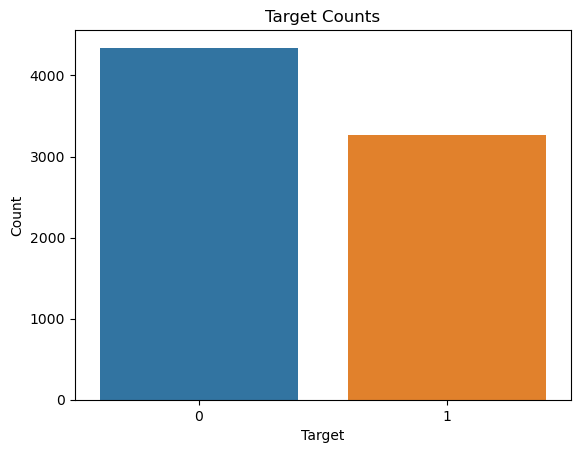

In [14]:
sns.countplot(x='target', data=df_train)
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

<b>Data Characteristics</b>

The dataset consists of 7,613 tweets, with 4,342 labeled as "Non-Disaster" and 3,271 labeled as "Disaster." Each tweet varies in length and is accompanied by a binary label indicating its category.

This setup is typical in text-based machine learning tasks, where the input is the tweet's text and the output is the classification label. Preprocessing steps like tokenization and vectorization will be necessary to prepare the data for modeling. Note that there are columns for 'Keyword' and 'Location' that will not be used in our model because of the large amount of missing entries in both columns.

### Data Cleaning

The data cleaning process involvea converting all text to lowercase, removing URLs, HTML tags, punctuation, and special characters, and tokenizing the tweets into individual words. Stopwords will be removed to reduce noise. These steps will ensure the text data is clean, standardized, and ready for effective modeling.

In [15]:
# Text preprocessing 
df_train['cleaned_text'] = df_train['text'].str.lower().str.replace('[^\w\s]', '', regex=True)

In [16]:
# Function to remove stop words from a given text
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply the function to your text data
df_train['cleaned_text'] = df_train['cleaned_text'].apply(remove_stopwords)

# Display the cleaned text without stop words
print(df_train[['text', 'cleaned_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


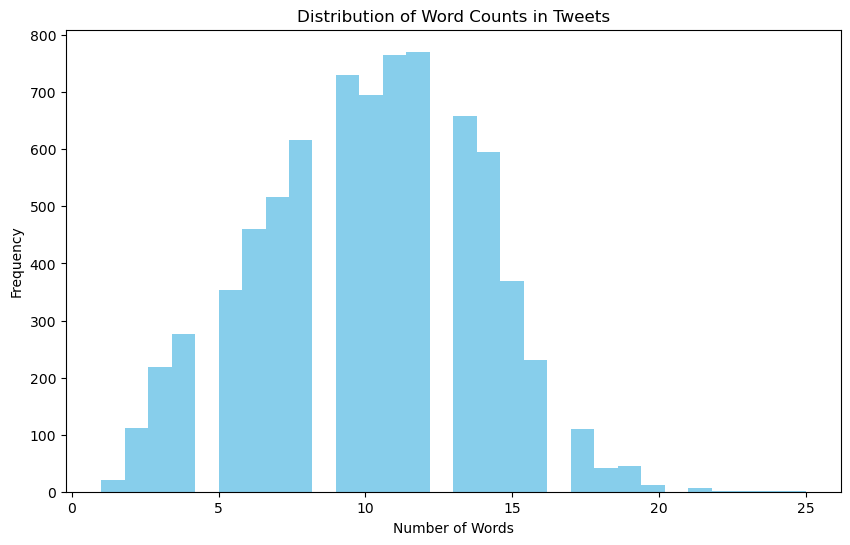

In [17]:
# Calculate word counts for each tweet
df_train['word_count'] = df_train['cleaned_text'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(df_train['word_count'], bins=30, color='skyblue')
plt.title('Distribution of Word Counts in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

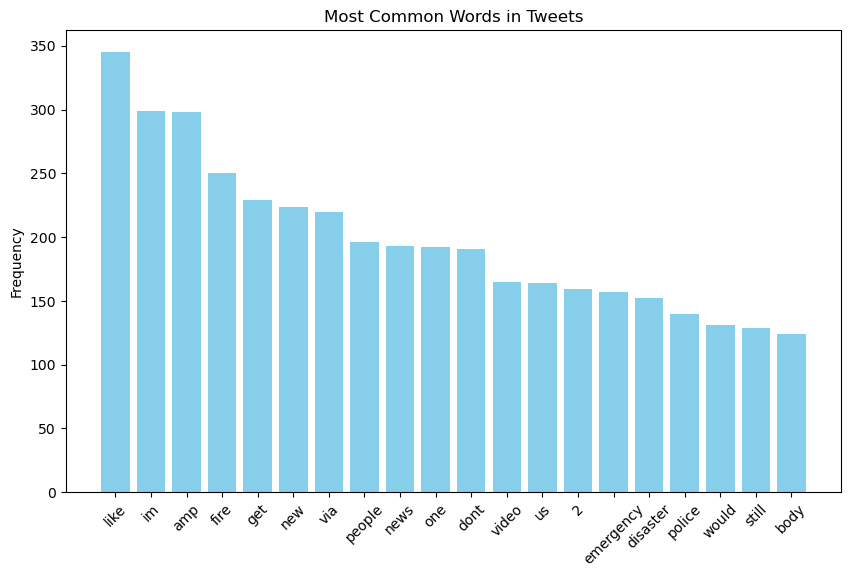

In [18]:
from collections import Counter

# Tokenize all the words in the dataset
all_words = ' '.join(df_train['cleaned_text']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words
common_words = word_counts.most_common(20)

# Convert to DataFrame for easier plotting
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the most common words
plt.figure(figsize=(10, 6))
plt.bar(common_words_df['word'], common_words_df['count'], color='skyblue')
plt.title('Most Common Words in Tweets')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

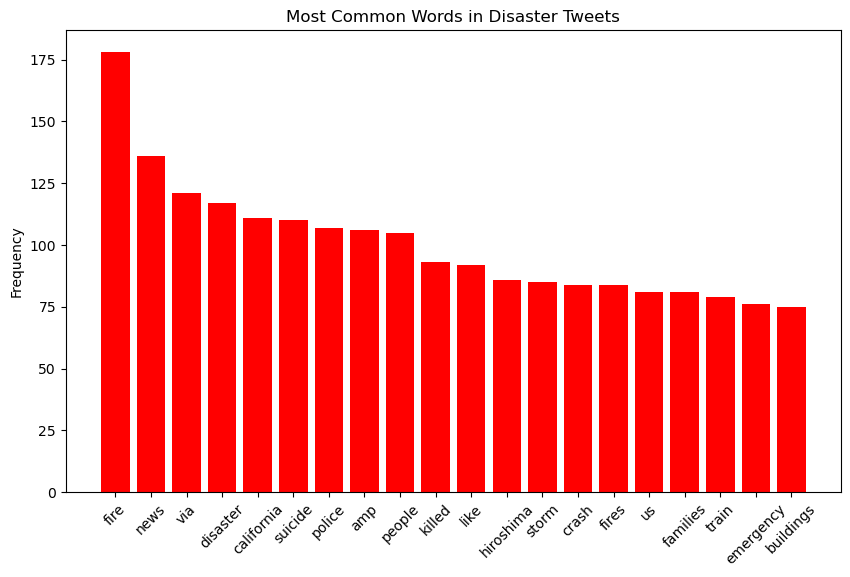

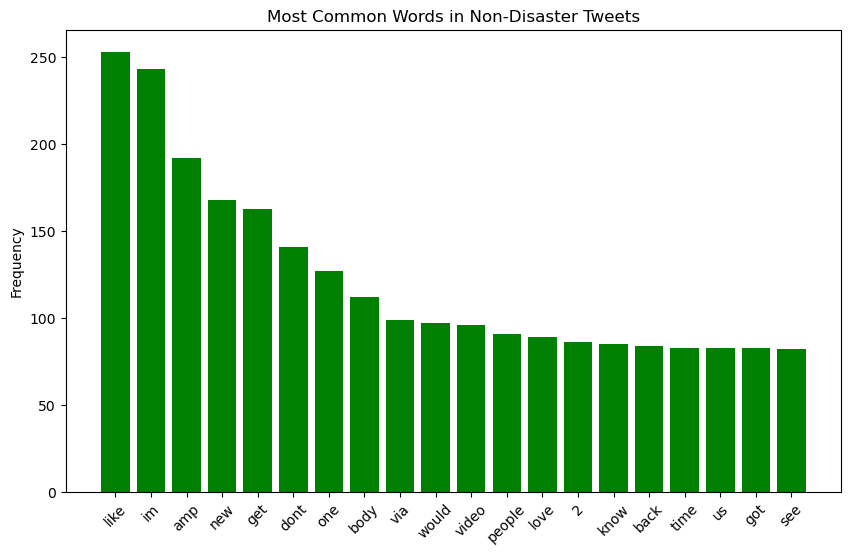

In [19]:
# Separate the data into disaster and non-disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['cleaned_text']
non_disaster_tweets = df_train[df_train['target'] == 0]['cleaned_text']

# Tokenize and count words for each category
disaster_words = ' '.join(disaster_tweets).split()
non_disaster_words = ' '.join(non_disaster_tweets).split()

disaster_word_counts = Counter(disaster_words).most_common(20)
non_disaster_word_counts = Counter(non_disaster_words).most_common(20)

# Convert to DataFrame for easier plotting
disaster_words_df = pd.DataFrame(disaster_word_counts, columns=['word', 'count'])
non_disaster_words_df = pd.DataFrame(non_disaster_word_counts, columns=['word', 'count'])

# Plot the most common words in disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(disaster_words_df['word'], disaster_words_df['count'], color='red')
plt.title('Most Common Words in Disaster Tweets')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Plot the most common words in non-disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(non_disaster_words_df['word'], non_disaster_words_df['count'], color='green')
plt.title('Most Common Words in Non-Disaster Tweets')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [20]:
# Extract text and labels
texts = df_train['cleaned_text'].values
labels = df_train['target'].values

In [21]:
# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [22]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

### Model Architecture

The first model below is a Simple RNN designed for binary classification, starting with an Embedding layer that turns words into dense vectors, followed by a Simple RNN layer to capture the sequence of words, and ending with a Dense layer using a sigmoid activation to output the probability of a tweet being a disaster. The following two models have similar architectures, however they usw LSTM and GRU layers before parameter tuning. The results from these three models will be compared and evaluated before parameter hypertuning.

In [23]:
# Build the Simple RNN model
model_1 = Sequential()
model_1.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_1.add(SimpleRNN(128)) 
model_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_1.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

2024-08-11 09:55:34.107024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 09:55:34.327562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
191/191 [==============================] - 6s 29ms/step - loss: 0.6101 - accuracy: 0.6588 - val_loss: 0.4895 - val_accuracy: 0.7676
Epoch 2/5
191/191 [==============================] - 5s 27ms/step - loss: 0.2918 - accuracy: 0.8883 - val_loss: 0.5074 - val_accuracy: 0.7735
Epoch 3/5
191/191 [==============================] - 5s 27ms/step - loss: 0.1404 - accuracy: 0.9560 - val_loss: 0.7120 - val_accuracy: 0.7288
Epoch 4/5
191/191 [==============================] - 5s 28ms/step - loss: 0.0843 - accuracy: 0.9760 - val_loss: 0.7136 - val_accuracy: 0.7472
Epoch 5/5
191/191 [==============================] - 5s 27ms/step - loss: 0.0597 - accuracy: 0.9803 - val_loss: 0.7539 - val_accuracy: 0.7472


In [24]:
# Evaluate the best model on the test set
loss_1, accuracy_1 = model_1.evaluate(X_val, y_val)
print(f'Test Accuracy: {accuracy_1}')

48/48 [==============================] - 0s 7ms/step - loss: 0.7539 - accuracy: 0.7472
Test Accuracy: 0.7472094297409058


In [25]:
# Build the RNN model
model_2 = Sequential()
model_2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_2.add(LSTM(128, return_sequences=True))
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_2.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
191/191 [==============================] - 17s 84ms/step - loss: 0.6817 - accuracy: 0.5779 - val_loss: 0.6736 - val_accuracy: 0.5916
Epoch 2/5
191/191 [==============================] - 16s 84ms/step - loss: 0.6657 - accuracy: 0.5913 - val_loss: 0.6671 - val_accuracy: 0.5937
Epoch 3/5
191/191 [==============================] - 18s 96ms/step - loss: 0.6611 - accuracy: 0.5929 - val_loss: 0.6680 - val_accuracy: 0.5930
Epoch 4/5
191/191 [==============================] - 17s 91ms/step - loss: 0.6517 - accuracy: 0.5975 - val_loss: 0.6694 - val_accuracy: 0.5927
Epoch 5/5
191/191 [==============================] - 17s 87ms/step - loss: 0.6473 - accuracy: 0.5991 - val_loss: 0.6755 - val_accuracy: 0.5921


In [26]:
# Evaluate the best model on the test set
loss_2, accuracy_2 = model_2.evaluate(X_val, y_val)
print(f'Test Accuracy: {accuracy_2}')

48/48 [==============================] - 1s 25ms/step - loss: 0.6755 - accuracy: 0.5921
Test Accuracy: 0.5921011567115784


In [27]:
# Build the GRU model
model_3 = Sequential()
model_3.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_3.add(GRU(128, return_sequences=True))
model_3.add(Dense(1, activation='sigmoid'))  

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_3.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
191/191 [==============================] - 15s 70ms/step - loss: 0.6823 - accuracy: 0.5789 - val_loss: 0.6751 - val_accuracy: 0.5902
Epoch 2/5
191/191 [==============================] - 13s 70ms/step - loss: 0.6684 - accuracy: 0.5840 - val_loss: 0.6722 - val_accuracy: 0.5932
Epoch 3/5
191/191 [==============================] - 13s 66ms/step - loss: 0.6569 - accuracy: 0.5952 - val_loss: 0.6700 - val_accuracy: 0.5934
Epoch 4/5
191/191 [==============================] - 13s 66ms/step - loss: 0.6502 - accuracy: 0.5980 - val_loss: 0.6717 - val_accuracy: 0.5923
Epoch 5/5
191/191 [==============================] - 13s 66ms/step - loss: 0.6454 - accuracy: 0.5998 - val_loss: 0.6762 - val_accuracy: 0.5914


In [28]:
# Evaluate the best model on the test set
loss_3, accuracy_3 = model_3.evaluate(X_val, y_val)
print(f'Test Accuracy: {accuracy_3}')

48/48 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.5914
Test Accuracy: 0.5913787484169006


The Simple RNN model outperformed the other architectures, achieving a test accuracy of 0.74, compared to 0.59 for both the LSTM and GRU models. This suggests that, for this particular dataset and task, the Simple RNN was better at capturing the necessary patterns in the tweet sequences. While LSTM and GRU are generally more powerful in handling complex sequential dependencies, the simpler structure of the RNN might have been more effective given the nature and size of this dataset. This result indicates that, sometimes, less complex models can yield better performance, especially in cases where the data may not require the advanced capabilities of more complex architectures.

That being said, we plan to use hyperparameter tuning to optimize the models further and potentially develop a more effective architecture. By fine-tuning parameters such as dropout rate, the optimizer, and the type of RNN, we aim to improve the overall performance and possibly surpass the current results.

In [52]:
def build_rnn_model(dropout=0.5, optimizer='adam', rnn_type='SimpleRNN'):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    
    if rnn_type == 'SimpleRNN':
        model.add(SimpleRNN(128))
    elif rnn_type == 'LSTM':
        model.add(LSTM(128, return_sequences=True))
    elif rnn_type == 'GRU':
        model.add(GRU(128, return_sequences=True))

    model.add(Dense(1, activation='sigmoid'))
    model.add(Dropout(dropout))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=build_rnn_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'dropout': [0.7, 0.5, 0.3],  
    'optimizer': ['adam', 'rmsprop'], 
    'rnn_type': ['SimpleRNN', 'LSTM', 'GRU']
}

In [56]:
# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1)

# Run the search
random_search_result = random_search.fit(X_train, y_train)

# Output the best hyperparameters
print(f'Best Hyperparameters: {random_search_result.best_params_}')
print(f'Best Accuracy: {random_search_result.best_score_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


2024-08-09 20:46:37.293282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:46:37.293282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 20:46:37.293282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Best Hyperparameters: {'rnn_type': 'SimpleRNN', 'optimizer': 'adam', 'dropout': 0.3}
Best Accuracy: 0.6364531914393107


In [59]:
# Evaluate the best model on the test set
best_model = random_search_result.best_estimator_.model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Test Accuracy: {accuracy}')

48/48 [==============================] - 1s 8ms/step - loss: 0.5686 - accuracy: 0.7118
Test Accuracy: 0.7117531299591064


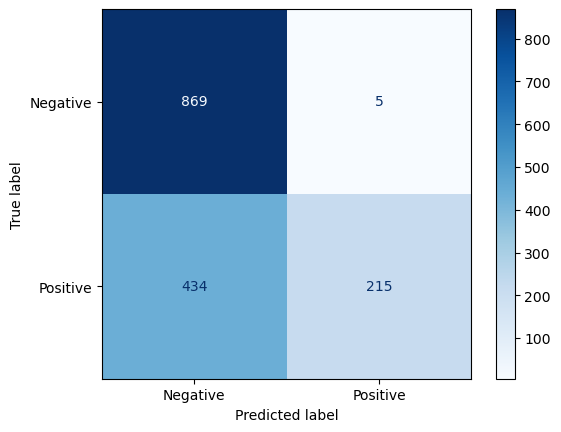

In [61]:
# Predict labels for the test set
y_pred = (best_model.predict(X_val) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [62]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_val, y_pred, target_names=['Non-Disaster', 'Disaster'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

Non-Disaster       0.67      0.99      0.80       874
    Disaster       0.98      0.33      0.49       649

    accuracy                           0.71      1523
   macro avg       0.82      0.66      0.65      1523
weighted avg       0.80      0.71      0.67      1523



### Summary of the Results from the Best Model after Hyperparameter Tuning

For Non-Disaster tweets, the model performed well, with a precision of 0.67 and a recall of 0.99, resulting in an F1-score of 0.80. This indicates that the model was mostly accurate when predicting non-disaster tweets and successfully identified nearly all of them.

However, for Disaster tweets, while the model achieved a high precision of 0.98, meaning it was almost always correct when it flagged a tweet as a disaster, the recall was only 0.33. This suggests the model missed a significant number of actual disaster tweets, this is reflected in a lower F1-score of 0.49.

Overall, the model reached an accuracy of 0.71, indicates there’s still room for improvement, particularly in detecting disaster tweets. The macro average F1-score of 0.65 and the weighted average of 0.67 highlight that the model is generally effective but tends to be more accurate in identifying non-disasters than disasters. These results represent the performance of our best model following hyperparameter tuning.

Even though these were the best results following hyperparameter tuning, it still appears like the first model that we designed above might before better. Below is the classification report for that model.

### Classification Report for First Model

In [31]:
# Predict labels for the test set
y_pred_model_1 = (model_1.predict(X_val) > 0.5).astype("int32")

# Generate the classification report
report_model_1 = classification_report(y_val, y_pred_model_1, target_names=['Non-Disaster', 'Disaster'])

# Print the classification report
print(report_model_1)

              precision    recall  f1-score   support

Non-Disaster       0.77      0.80      0.78       874
    Disaster       0.72      0.67      0.69       649

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



### Analysis of Results and Conclusions

Comparing these results with those from the best model after hyperparameter tuning, the initial model shows a more balanced performance across both classes.

For Non-Disaster tweets, the first model had a precision of 0.77 and a recall of 0.80, with an F1-score of 0.78. This is slightly higher in precision and F1-score compared to the tuned model, which had a precision of 0.67 but a higher recall of 0.99.

For Disaster tweets, the first model achieved a precision of 0.72 and a recall of 0.67, with an F1-score of 0.69. This is a more balanced performance compared to the tuned model, which had a higher precision of 0.98 but a much lower recall of 0.33.

The overall accuracy of the first model was 0.75, which is slightly better than the 0.71 accuracy of the tuned model. The macro and weighted averages for precision, recall, and F1-score were all 0.74 or 0.75, indicating a more consistent performance across both classes compared to the tuned model.

In summary, while the tuned model was more precise in identifying disaster tweets, the first model offered a better balance between precision and recall for both classes, leading to slightly better overall accuracy and more consistent performance metrics.

With that being said, the first model that was trained will be used for the kaggle competition. 

### Prepare and Predict on Test Set

In [32]:
# Load the dataset
df_test = pd.read_csv('test.csv')

In [33]:
# Text preprocessing
df_test['cleaned_text'] = df_test['text'].str.lower().str.replace('[^\w\s]', '', regex=True)

In [34]:
# Function to remove stop words from a given text
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply the function to your text data
df_test['cleaned_text'] = df_test['cleaned_text'].apply(remove_stopwords)

# Display the cleaned text without stop words
print(df_test[['text', 'cleaned_text']].head())

                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan   

                                        cleaned_text  
0                        happened terrible car crash  
1  heard earthquake different cities stay safe ev...  
2  forest fire spot pond geese fleeing across str...  
3              apocalypse lighting spokane wildfires  
4             typhoon soudelor kills 28 china taiwan  


In [35]:
# Extract text and labels
test_texts = df_test['cleaned_text'].values

In [36]:
# Tokenization
max_words = 10000
tokenizer_test = Tokenizer(num_words=max_words)
tokenizer_test.fit_on_texts(test_texts)
sequences_test = tokenizer.texts_to_sequences(test_texts)
max_len = 100
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len)

In [38]:
# Predict labels for the test set
y_pred_test = (model_1.predict(padded_sequences_test) > 0.5).astype("int32")

In [41]:
predictions_df = pd.DataFrame(y_pred_test, columns=['Predictions'])
predictions_df.to_csv('predictions.csv', index=False)

### References

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

GeeksforGeeks. (n.d.). Natural Language Processing (NLP) Overview. Retrieved from https://www.geeksforgeeks.org/natural-language-processing-overview/.

TensorFlow. (n.d.). Working with RNNs. Retrieved from https://www.tensorflow.org/guide/keras/working_with_rnns.

TensorFlow. (n.d.). tf.keras.preprocessing.text. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text.